# 8-2. 합성곱 신경망을 사용한 이미지 분류

MINST 데이터셋에 CNN사용하여 이미지 분류하기

### 데이터 불러와 전처리하기

다음의 reshape을 통해 (48000,28,28) 크기인 train_input이 (48000,28,28,1)크기인 4차원 배열 train_scaled가 된다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

### 합성곱 신경망 만들기

Sequential 클래스의 객체를 만들고 첫번째 합성곱 층인 Conv2D를 추가. 

In [3]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))

32개의 필터 사용. 커널의 크기는 (3,3)로 지정. input_shape에 입력의 차원을 지정해줘야한다.

In [4]:
# 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2))

MINST 이미지가 (28,28)이고 same padding을 이용했으므로 출력된 특성 맵의 가로세로 크기는 입력과 동일하다. 풀링은 (2,2)로 적용했으므로 특성 맵의 크기는 반으로 줄어든다. 첫번째 층을 통과한 출력의 크기는 (14,14,32)가 된다. 필터의 개수가 32이기때문에 특성 맵의 깊이는 32가 된다

두번째 합성곱 - 풀링층 추가하기. 첫번째와 동일하나 필터 개수를 64개로 늘린다는 게 차이점

In [5]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

두번째 층을 통과하고나면 특성 맵은 (7,7,64)가 된다. 다음으로는 3차원 배열을 일렬로 펼칠 차례인데 이는 10개의 뉴런을 가진 밀집 출력층에서 확률을 계산해야하기 때문이다.

In [6]:
# 3차원 배열 일렬로 펼치기: Faltten()
model.add(keras.layers.Flatten())

# 은닉층: 100개의 뉴런 사용
model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dropout(0.4))

# # 10개의 클래스로 분류하는 출력층에 뉴런
model.add(keras.layers.Dense(10, activation='softmax'))

#### 모델의 구성 확인

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

In [9]:
# pip install pydot

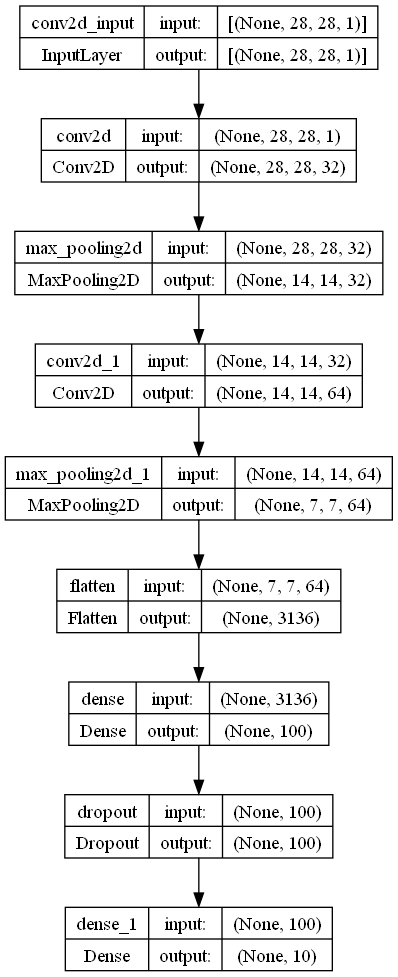

In [8]:
# 모델 층의 구성 그림으로 시각화
#keras.utils.plot_model(model)
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

* Adam 옵티마이저 사용
* ModelCheckpoint 콜백과 EarlyStopping 콜백 함께 사용

In [10]:

# compile(): 모델에 사용핳 옵티마이저, 손실함수, 성능평가 지표 지정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 30s 18ms/step - loss: 0.5216 - accuracy: 0.8150 - val_loss: 0.3338 - val_accuracy: 0.8764
Epoch 2/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3494 - accuracy: 0.8720 - val_loss: 0.2808 - val_accuracy: 0.8961
Epoch 3/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2968 - accuracy: 0.8919 - val_loss: 0.2522 - val_accuracy: 0.9041
Epoch 4/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2643 - accuracy: 0.9042 - val_loss: 0.2431 - val_accuracy: 0.9095
Epoch 5/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2402 - accuracy: 0.9113 - val_loss: 0.2365 - val_accuracy: 0.9116
Epoch 6/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2226 - accuracy: 0.9189 - val_loss: 0.2210 - val_accuracy: 0.9183
Epoch 7/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2051 - accuracy: 0.9234 - val_loss: 0.2249 -

In [11]:
import matplotlib.pyplot as plt

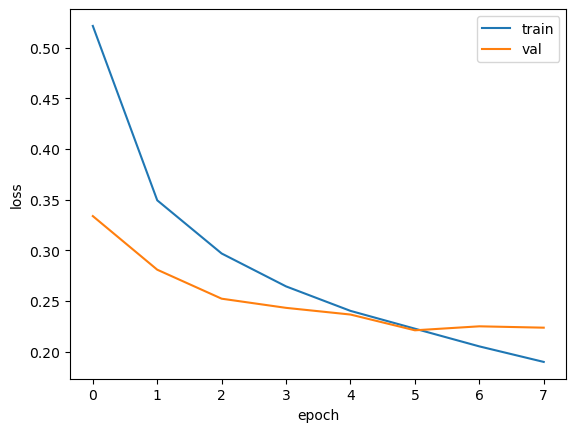

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

다음의 그래프는 조기종료 조건이 잘 수행되었는지 확인하기 위한 그래프로 epoche 9번째에서 조기종료하는 것이 최적이라고 생각할 수 있다. 

evaluate()로 확인해보면 아홉번째 에포크 출력과 동일하다. 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원한 것으로 볼 수 있다.

In [13]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.2210 - accuracy: 0.9183


[0.22097446024417877, 0.9183333516120911]

다음은 predict() 매서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 만들어 확인해보자. 


plt은 흑백 이미지에서는 깊이 차원이 없음 (28,28,1) 크기를 (28,28)로 바꿔 출력해야함


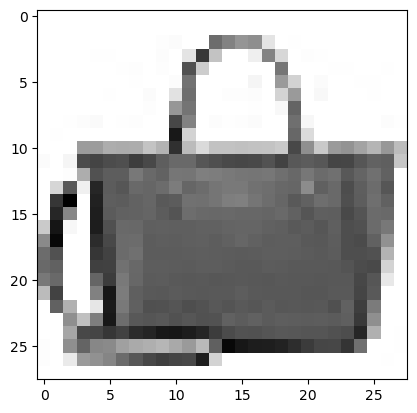

In [15]:
# 샘플 이미지 확인
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [16]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 2s 2s/step
[[2.6454438e-16 1.0612940e-25 5.2937845e-17 1.1728912e-18 3.8848401e-16
  2.1057750e-20 1.5906045e-17 2.1031762e-18 1.0000000e+00 4.5278146e-21]]


다음은 해당 샘플 데이터가 10개 클래스에 대한 확률값이다. 다음은 아홉번째 클래스가 1이고 나머지는 e의 값을 가진 0에 가까운 값이다. 

In [18]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [19]:
import numpy as np
print(classes[np.argmax(preds)])

가방
